accuracy:0.76


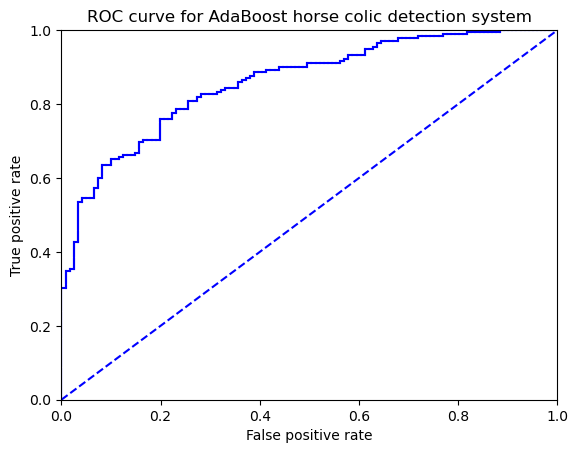

the Area Under the Curve is:  0.8582969635063604


In [1]:


import numpy as np


# 在这个案例中正确分类，要求标签是-1和+1，sign函数方便

def load_simple_data():
    # 自定义简单的测试数据
    data_mat = np.matrix([
        [1., 2.1],
        [2., 1.1],
        [1.3, 1.],
        [1., 1.],
        [2., 1.],
    ])
    # 二值label
    class_labels = [1., 1., -1., -1., 1.]
    return data_mat, class_labels


def load_data_set(filename):  # general function to parse tab -delimited floats
    # 加载外部的数据源，这里用的是之前用过的患马病的概率
    # 读取特征字段
    num_feature = len(open(filename).readline().split('\t'))  # get number of fields
    data_mat = []
    label_mat = []
    fr = open(filename)
    for line in fr.readlines():
        line_arr = []
        cur_line = line.strip().split('\t')
        for i in range(num_feature - 1):
            line_arr.append(float(cur_line[i]))
        # 中间的数据都是特征
        data_mat.append(line_arr)
        # 最后一个是标签
        label_mat.append(float(cur_line[-1]))
    return data_mat, label_mat


def stump_classify(data_matrix, dimen, thresh_val, thresh_ineq):  # just classify the data

    # 通过阈值比较，一边分成-1，一边为1，可以通过数组对比
    ret_array = np.ones((np.shape(data_matrix)[0], 1))
    # 看看是哪一边取-1
    if thresh_ineq == 'lt':
        ret_array[data_matrix[:, dimen] <= thresh_val] = -1.0
    else:
        ret_array[data_matrix[:, dimen] > thresh_val] = -1.0
    return ret_array


# 这是一个弱决策器
def build_stump(data_arr, class_labels, d):
    # 遍历所有可能的值到stump_classify种，找到最佳的单层决策树
    # 这里的最佳是通过权重向量d来定义
    data_matrix = np.mat(data_arr)
    label_mat = np.mat(class_labels).T  # 让它站起来
    m, n = np.shape(data_matrix)
    num_steps = 10.0  # 在特征所有可能值上遍历，超出也无所谓
    best_stump = {}  # 这个字典存储给定权重d时所得到的最佳决策树相关信息
    best_clas_est = np.mat(np.zeros((m, 1)))
    min_error = np.inf  # init error sum, to +infinity，一开始被初始为无穷大
    for i in range(n):  # loop over all dimensions一层在所有特征上遍历
        range_min = data_matrix[:, i].min()  # 固定列的最小值
        range_max = data_matrix[:, i].max()
        step_size = (range_max - range_min) / num_steps  # 设定步长
        # 二层遍历所有当前特征
        for j in range(-1, int(num_steps) + 1):  # loop over all range in current dimension
            # 在大于小于特征间切换不等式
            for inequal in ['lt', 'gt']:  # go over less than and greater than
                thresh_val = (range_min + float(j) * step_size)  # 阈值慢慢挪动
                # 调用前面定义的分类函数
                predicted_vals = stump_classify(data_matrix, i, thresh_val,
                                                inequal)  # call stump classify with i, j, lessThan
                err_arr = np.mat(np.ones((m, 1)))
                err_arr[predicted_vals == label_mat] = 0  # 分错了就是0
                weighted_error = d.T * err_arr  # calc total error multiplied by D

                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (
                #     i, thresh_val, inequal, weighted_error))
                if weighted_error < min_error:
                    # 如果找到了一个最好的版本，就全部换成这个
                    min_error = weighted_error
                    best_clas_est = predicted_vals.copy()
                    best_stump['dim'] = i
                    best_stump['thresh'] = thresh_val
                    best_stump['ineq'] = inequal
    return best_stump, min_error, best_clas_est


def adaboost_trainDS(data_arr, class_labels, num_iter=40):
    # 输入，数据集，类别标签，迭代次数num_iter
    # DS,单层决策树，decision stump，最流行的弱分类器。但事实上，任何分类器都可以充当弱分类器
    weak_class_arr = []  # 一个单层决策树的数组
    m = np.shape(data_arr)[0]
    d = np.mat(np.ones((m, 1)) / m)  # init D to all equal  # 包含数据点的权值
    agg_class_est = np.mat(np.zeros((m, 1)))  # 每个数据点类别估计累计值
    for i in range(num_iter):
        # 第一件事就是建树，返回的是利用d而得到的具有最小错误率的单层决策树
        # 同时还返回最小错误率及估计的类别向量
        best_stump, error, class_est = build_stump(data_arr, class_labels, d)  # build Stump
        # print("d:", d.T)
        # 重头戏，估计alpha值，告诉总分类器本次单层决策树输出结果的权重
        # 1e-16是避免除零溢出
        alpha = float(0.5 * np.log(
            (1.0 - error) / max(error, 1e-16)))  # calc alpha, throw in max(error,eps) to account for error=0
        # 接下来把分类器和权重都放进去
        best_stump['alpha'] = alpha
        weak_class_arr.append(best_stump)  # store Stump Params in Array
        # print("classEst: ", class_est.T)
        expon = np.multiply(-1 * alpha * np.mat(class_labels).T, class_est)  # exponent for D calc, getting messy
        d = np.multiply(d, np.exp(expon))  # Calc New D for next iteration
        d = d / d.sum()
        # calc training error of all classifiers, if this is 0 quit for loop early (use break)
        agg_class_est += alpha * class_est
        # print("aggClassEst: ", agg_class_est.T)
        # sign是保证结果是二值的
        agg_errors = np.multiply(np.sign(agg_class_est) != np.mat(class_labels).T, np.ones((m, 1)))
        error_rate = agg_errors.sum() / m
        # print("total error: ", error_rate)
        if error_rate == 0.0: break  # 运行直到误分类为0
    return weak_class_arr, agg_class_est


def ada_classify(dat2class, classifier_arr):
    # 输入是待分样例和弱分类器集合
    # 仅仅是利用了前面训练好的分类器
    data_matrix = np.mat(dat2class)  # do stuff similar to last aggClassEst in adaBoostTrainDS
    m = np.shape(data_matrix)[0]
    agg_class_est = np.mat(np.zeros((m, 1)))  # 全0列向量
    for i in range(len(classifier_arr)):  # 遍历所有的弱分类器
        # 用单层决策树获得每个分类器自己的决策值
        class_est = stump_classify(data_matrix, classifier_arr[i]['dim'], classifier_arr[i]['thresh'],
                                   classifier_arr[i]['ineq'])  # call stump classify
        # 输出结果是累加
        agg_class_est += classifier_arr[i]['alpha'] * class_est
        # print(agg_class_est)  # 这个例子中，值越来越小
    # 要满足不超界，大于0为+1，小于0为-1
    return np.sign(agg_class_est)


# 因为可能会过拟合，这时候就要求我们选一个合适的指标来判断多少个分类器合适，比如ROC
def plotROC(pred_strengths, class_labels):
    # AUC，曲线下的面积
    import matplotlib.pyplot as plt
    cur = (1.0, 1.0)  # cursor  # 起始点
    y_sum = 0.0  # variable to calculate AUC
    num_pos_clas = sum(np.array(class_labels) == 1.0)  # 正例的数目
    # 这两个是步长
    y_step = 1 / float(num_pos_clas)
    x_step = 1 / float(len(class_labels) - num_pos_clas)
    # 从小到大排列，再得到下标
    sorted_indicies = pred_strengths.argsort()  # get sorted index, it's reverse
    fig = plt.figure()
    fig.clf()  # 清空
    ax = plt.subplot(111)
    # loop through all the values, drawing a line segment at each point
    for index in sorted_indicies.tolist()[0]:  # np对象变成list
        if class_labels[index] == 1.0:
            del_x = 0
            del_y = y_step
        else:
            del_x = x_step
            del_y = 0
            y_sum += cur[1]
        # draw line from cur to (cur[0]-delX,cur[1]-delY)
        ax.plot([cur[0], cur[0] - del_x], [cur[1], cur[1] - del_y], c='b')
        cur = (cur[0] - del_x, cur[1] - del_y)
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0, 1, 0, 1])
    plt.show()
    print("the Area Under the Curve is: ", y_sum * x_step)


def test():

    d = np.mat(np.ones([5, 1]) / 5)
    data_mat, class_labels = load_simple_data()
    # build_stump(data_mat, class_labels, d)
    classifier_arr, _ = adaboost_trainDS(data_mat, class_labels, 30)  # 第二个参数暂时没用
    ada_classify([0, 0], classifier_arr)


def test_horse():
    data_arr, label_arr = load_data_set('horseColicTraining2.txt')
    classifier_array, agg_class_est = adaboost_trainDS(data_arr, label_arr, 10)

    # 用训练好的数据来
    test_arr, test_label_arr = load_data_set('horseColicTest2.txt')
    prediction = ada_classify(test_arr, classifier_array)

    err_arr = np.mat(np.ones([67, 1]))
    err_num = err_arr[prediction != np.mat(test_label_arr).T].sum()
    print("accuracy:%.2f" % (1 - err_num / float(67)))
    # 错了16个,准确率只有0.76
    # 但是用logistic错误率有0.35，这里只用了很少弱分类器
    # 分类器再多会导致过拟合
    plotROC(agg_class_est.T, label_arr)


if __name__ == '__main__':
    # test()  # 简单测试
    test_horse()  # 马病测试
